In [13]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GATConv
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE


In [14]:
dataset = Planetoid(root='../data', name='Cora')
data = dataset[0].to(device)

Processing...
/Users/adityaprathapa/graph-attention-networks/venv/lib/python3.12/site-packages/torch_geometric/io/planetoid.py:107: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  out = pickle.load(f, encoding='latin1')
/Users/adityaprathapa/graph-attention-networks/venv/lib/python3.12/site-packages/torch_geometric/io/planetoid.py:107: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  out = pickle.load(f, encoding='latin1')
/Users/adityaprathapa/graph-attention-networks/venv/lib/python3.12/site-packages/torch_geometric/io/planetoid.py:107: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2

In [20]:
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8, dropout=0.6):
        super().__init__()
        self.dropout = dropout

        # Layer 1: 8 attention heads, each producing 8 features
        # Output: 64 features (concatenated)
        self.conv1 = GATConv(
            in_channels, hidden_channels, heads=heads, dropout=dropout
        )

        # Layer 2: 1 attention head for classification
        # Input: 64 (from concat above)
        # Output: 7 classes
        self.conv2 = GATConv(
            hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout
        )

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

    def get_embeddings(self, x, edge_index):
        """Extract layer-1 embeddings for t-SNE visualization later."""
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        return x


model = GAT(
    in_channels=dataset.num_features,   
    hidden_channels=8,                   
    out_channels=dataset.num_classes,    
    heads=8,
    dropout=0.6
).to(device)

In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

train_losses = []
train_accs = []
val_accs = []


def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    pred = out[data.train_mask].argmax(dim=1)
    acc = (pred == data.y[data.train_mask]).sum().item() / data.train_mask.sum().item()
    return loss.item(), acc


@torch.no_grad()
def evaluate(mask):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out[mask].argmax(dim=1)
    acc = (pred == data.y[mask]).sum().item() / mask.sum().item()
    return acc


best_val_acc = 0
for epoch in range(1, 201):
    loss, train_acc = train()
    val_acc = evaluate(data.val_mask)

    train_losses.append(loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc

    if epoch % 20 == 0: # Print every 20 epochs
        print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

print(f"\nBest Validation Accuracy: {best_val_acc:.4f}")


Epoch 020 | Loss: 0.9474 | Train Acc: 0.7571 | Val Acc: 0.7680
Epoch 040 | Loss: 0.6675 | Train Acc: 0.8143 | Val Acc: 0.7720
Epoch 060 | Loss: 0.4361 | Train Acc: 0.8571 | Val Acc: 0.7820
Epoch 080 | Loss: 0.5217 | Train Acc: 0.8214 | Val Acc: 0.7680
Epoch 100 | Loss: 0.3385 | Train Acc: 0.9071 | Val Acc: 0.7640
Epoch 120 | Loss: 0.4031 | Train Acc: 0.8500 | Val Acc: 0.7940
Epoch 140 | Loss: 0.3783 | Train Acc: 0.8714 | Val Acc: 0.7820
Epoch 160 | Loss: 0.3817 | Train Acc: 0.8857 | Val Acc: 0.7600
Epoch 180 | Loss: 0.4985 | Train Acc: 0.8214 | Val Acc: 0.7660
Epoch 200 | Loss: 0.3777 | Train Acc: 0.8714 | Val Acc: 0.7760

Best Validation Accuracy: 0.7940


In [22]:
test_acc = evaluate(data.test_mask)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"(Target: ~0.83 based on original GAT paper)")

Test Accuracy: 0.8010
(Target: ~0.83 based on original GAT paper)


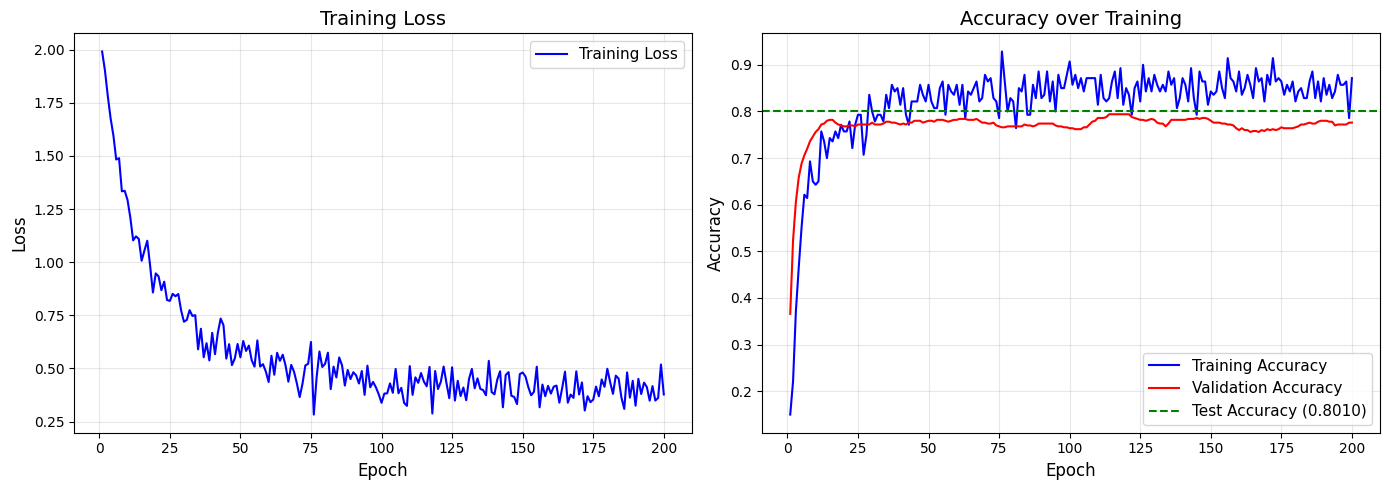

Saved to results/training_curves.png


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

epochs = range(1, len(train_losses) + 1)

# Loss curve
ax1.plot(epochs, train_losses, 'b-', linewidth=1.5, label='Training Loss')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training Loss', fontsize=14)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Accuracy curves
ax2.plot(epochs, train_accs, 'b-', linewidth=1.5, label='Training Accuracy')
ax2.plot(epochs, val_accs, 'r-', linewidth=1.5, label='Validation Accuracy')
ax2.axhline(y=test_acc, color='g', linestyle='--', linewidth=1.5, label=f'Test Accuracy ({test_acc:.4f})')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Accuracy over Training', fontsize=14)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



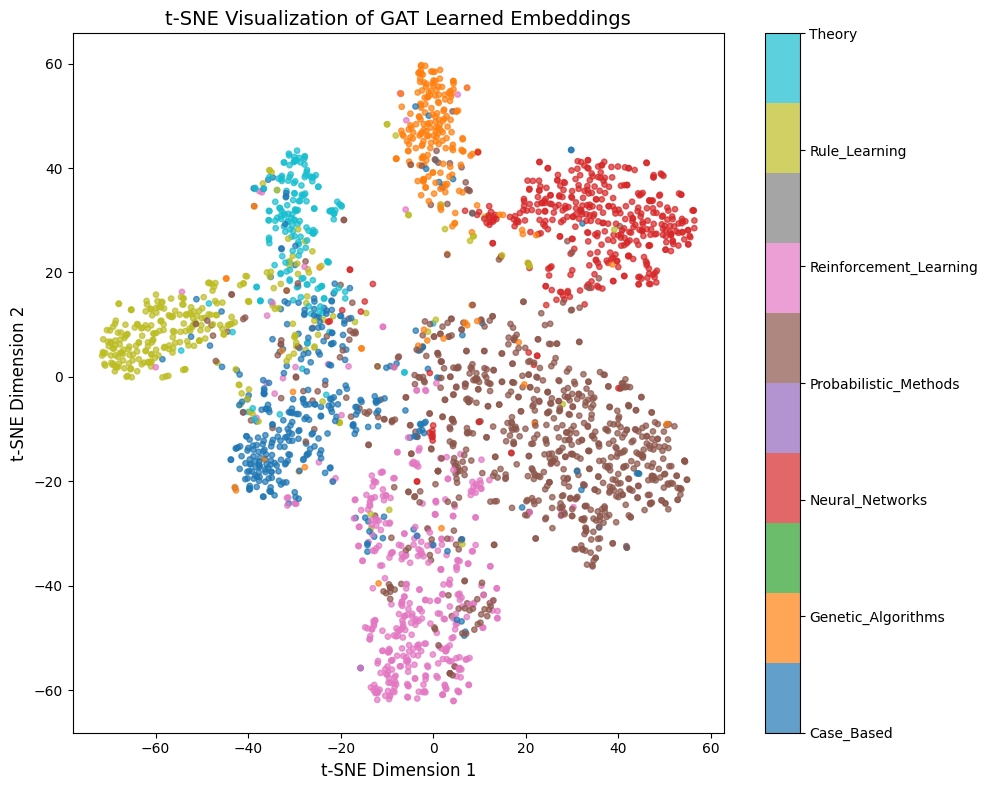

Saved to results/tsne_embeddings.png


In [ ]:
model.eval()
with torch.no_grad():
    embeddings = model.get_embeddings(data.x, data.edge_index)

embeddings_np = embeddings.cpu().numpy()
labels_np = data.y.cpu().numpy()

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings_np)

class_names = [
    'Case_Based', 'Genetic_Algorithms', 'Neural_Networks',
    'Probabilistic_Methods', 'Reinforcement_Learning', 'Rule_Learning', 'Theory'
]

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    embeddings_2d[:, 0], embeddings_2d[:, 1],
    c=labels_np, cmap='tab10', s=15, alpha=0.7
)

cbar = plt.colorbar(scatter, ticks=range(7))
cbar.ax.set_yticklabels(class_names)
plt.title('t-SNE Visualization of GAT Learned Embeddings', fontsize=14)
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.tight_layout()
plt.show()
